# Tutorial - Fundamentals of Neural Network Training with Image-based Regression

#### Author: Antonio Rueda-Toicen

**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).


The pixels on an image each represent an input unit on the input layer. If the input image has 224x224 pixels, each them is a unit on the input (such network requires 50176 input units).

We have as many units on the output layer as values that we want to predict. If we are to predict only single value (e.g. price, age, height) given an image, we have a single output unit.

The number of hidden layers and the amount of units that we put in them are decisions that we make as designers of the model. We inform these decisions based on performance on a validation set for our problem. On the validation set, we might try different number of hidden layers and different number of units. We choose the combination that gives us the best performance based on the loss function or another metric related to our problem.

<img src="https://raw.githubusercontent.com/andandandand/images-for-colab-notebooks/refs/heads/main/Screenshot%202025-03-07%20at%2011.43.55.png" width="300" height="300">

[Diagram of a multilayer perceptron](https://alexlenail.me/NN-SVG/index.html) where the width of edges is proportional to their weights and their colors blue when negative, red when positive.

## What does it mean to "train" a neural network?

$$w_{ij} = w_{ij} - \left(\text{learning rate} * \frac{dL}{dw_{ij}}\right)$$

Using the gradient of the loss function to update the weights. In this notebook we go deep into how this is implemented in pure PyTorch.

As practitioners, in 99.99% of use cases we **don't implement the weight update rule by hand**. We usually pass the parameters of the model to an instance of `torch.optim.optimizer` and then call `optimizer.step()`. In this notebook we explore how this process works by making a neural network learn the price of a car by training and evaluating on a single image. In the next notebook, we will explore **the importance of validation and test sets** to determine whether our network is [overfitting](https://developers.google.com/machine-learning/crash-course/overfitting/overfitting#:~:text=Overfitting%20means%20creating%20a%20model,worthless%20in%20the%20real%20world.) or [underfitting](https://www.ibm.com/think/topics/underfitting) to the data.


## Memorizing the data

In this notebook we are training a model using *a single image*,  forcing it to memorize the target value.

It's important to understand that, in the context most neural network training runs, generalization capabilities only arise when having a rich enough dataset that doesn't represent [spurious correlations](https://www.tylervigen.com/spurious-correlations) between between input and target variables. "Deep" learning only refers to having a "large" number of hidden layers, not finding the deepest secrets of the universe 😜.

"[Garbage in, garbage out](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out)" remains true)🗑️.


## Measuring error with a loss function

Any differentiable function where we can compute gradients with respect to the weights can be used to update them

$$L = \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$


## Parameters vs Hyperparameters

* Parameters = weights of the model
* Hyperparameters = network architecture, training setup, e.g. the number of hidden layers, the number of units on each, the learning rate

The learning rate is a particularly important and sensitive parameter that we explore in this notebook.



## Understanding the update rule on a network's weights

In [ ]:
import skimage.io as io
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt

In [ ]:
corvette_array = io.imread("https://github.com/andandandand/images-for-colab-notebooks/blob/main/1964-chevrolet-corvette-stingray.jpeg?raw=true")
# original image dimensions
corvette_array.shape

(1282, 1920, 3)

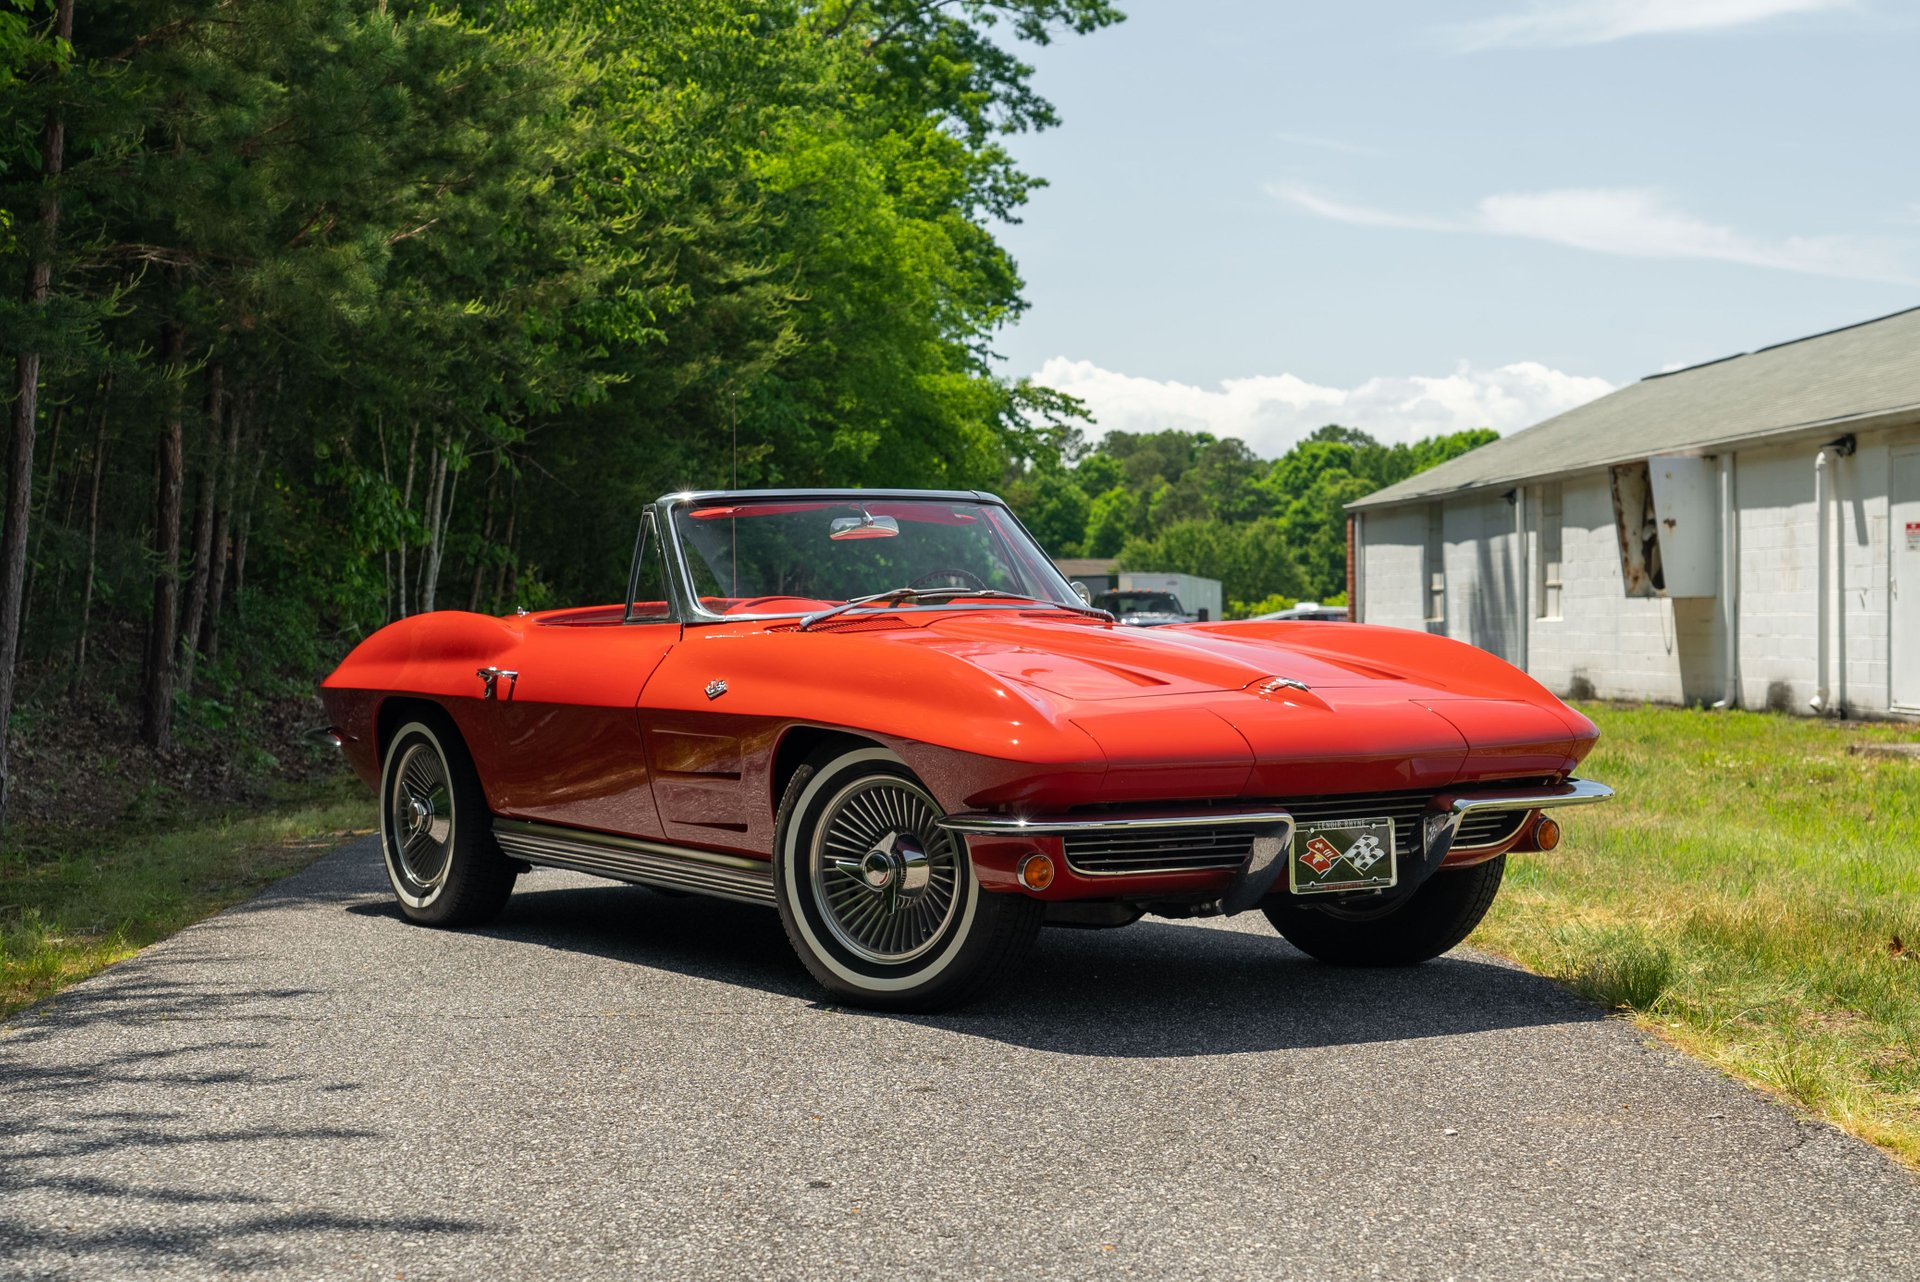

In [ ]:
Image.fromarray(corvette_array)

In [ ]:
# This is the true price which we are trying to make the network learn
y = torch.tensor(83999.)

In [ ]:
transform_to_square_tensor = transforms.Compose([
    transforms.ToImage(),
    # We first resize the image to Height=Width=224 to reduce the number of parameters
    transforms.Resize((224, 224)),
    transforms.ToDtype(torch.float32, scale=True)
])

In [ ]:
image_tensor = transform_to_square_tensor(corvette_array)
C, H, W = image_tensor.shape
print(C, H, W)

3 224 224


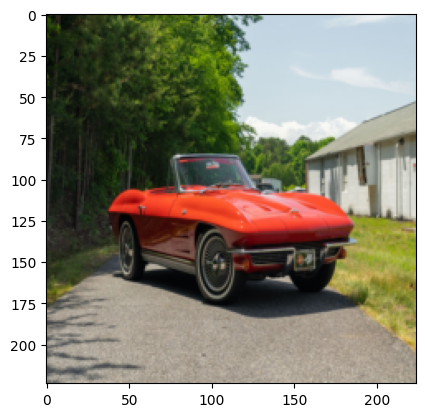

In [ ]:
plt.imshow(image_tensor.permute(1, 2 ,0));

In [ ]:
# Number of units on the hidden layer
p = 100
# We use nn.Sequential to concatenate PyTorch modules in order
# nn.Linear are modules for fully connected layers.
# The output of the first linear layer is sent to a ReLU function to introduce non-linearity.
multilayer_perceptron=nn.Sequential(
                      nn.Linear(in_features=C * H * W,
                                out_features=p,
                                bias=False),
                      nn.ReLU(),
                      nn.Linear(in_features=p,
                                out_features=1,
                                bias=False),
)
multilayer_perceptron

Sequential(
  (0): Linear(in_features=150528, out_features=100, bias=False)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=False)
)

In [ ]:
# What is inside the multilayer_perceptron is a sequence of nn.Module objects
# Each can take in inputs of the previous module and give outputs to the next
# The Sequential object can be accessed by its indices
len(multilayer_perceptron)

3

In [ ]:
# Our loss function
def absolute_error(y, y_hat):
    return torch.abs(y - y_hat)

In [ ]:
# We can acccess the weights of every fully connected layer
# These are the randomly initialized weights of the first layer
print(multilayer_perceptron[0].weight.shape)
multilayer_perceptron[0].weight

torch.Size([100, 150528])


Parameter containing:
tensor([[-2.5230e-03,  1.4821e-03, -1.0078e-03,  ..., -3.4149e-04,
          1.8346e-03,  2.3738e-03],
        [-1.2307e-03,  1.4003e-03, -4.0132e-05,  ..., -2.3735e-03,
         -1.1466e-03, -8.7249e-04],
        [ 3.4681e-04,  9.3417e-05,  2.5058e-03,  ...,  1.0468e-03,
         -1.6593e-03, -1.7282e-03],
        ...,
        [-6.9984e-06, -1.7043e-03, -2.2080e-03,  ...,  1.0766e-03,
         -6.0397e-04,  1.2967e-03],
        [ 1.4909e-03,  1.8430e-03, -1.3271e-03,  ...,  1.6658e-03,
          2.3048e-03,  8.9169e-04],
        [-2.5260e-03, -2.2136e-03,  9.0331e-04,  ...,  2.2287e-03,
         -1.7092e-03,  4.1076e-04]], requires_grad=True)

In [ ]:
# Notice that the dimension of the output appears first
print(multilayer_perceptron[2].weight.shape)
multilayer_perceptron[2].weight

torch.Size([1, 100])


Parameter containing:
tensor([[ 0.0481,  0.0341, -0.0366,  0.0610,  0.0816, -0.0548,  0.0838, -0.0989,
         -0.0224, -0.0927,  0.0054, -0.0903, -0.0413,  0.0278,  0.0153,  0.0655,
          0.0556,  0.0569, -0.0161, -0.0726,  0.0033,  0.0009,  0.0273,  0.0728,
          0.0541, -0.0634, -0.0738,  0.0037,  0.0727, -0.0787, -0.0820, -0.0931,
          0.0344,  0.0634,  0.0283,  0.0247,  0.0067,  0.0137,  0.0129, -0.0634,
         -0.0415,  0.0310,  0.0796,  0.0988,  0.0118, -0.0940, -0.0918,  0.0774,
          0.0061,  0.0421, -0.0912, -0.0570, -0.0896,  0.0839, -0.0027, -0.0057,
         -0.0763,  0.0376,  0.0507,  0.0131,  0.0803, -0.0318, -0.0184,  0.0895,
         -0.0427,  0.0302, -0.0639,  0.0792,  0.0244,  0.0732,  0.0569, -0.0849,
         -0.0221,  0.0340,  0.0727, -0.0427, -0.0188,  0.0428, -0.0320, -0.0482,
          0.0241,  0.0806,  0.0938,  0.0718,  0.0030, -0.0025, -0.0295, -0.0755,
          0.0986, -0.0844, -0.0683,  0.0294,  0.0036, -0.0281,  0.0393, -0.0651,
      

In [ ]:
# Notice that image_tensor has by default requires_grad = False
# as the values of the image tensor (the input) do not need to be updated
image_tensor.requires_grad

False

In [ ]:
# nn.Linear requires its input to be flattened, the image tensor as we have it now
# has to be reshaped
image_tensor.shape

torch.Size([3, 224, 224])

In [ ]:
# We flatten the tensor to make matrix multiplication work with the
# first layer of weights in the fully connected layer
image_tensor = image_tensor.flatten()
image_tensor.shape

torch.Size([150528])

In [ ]:
# We add a batch dimension, as it is a requirement for the input to instances of nn.Module
# You can try removing the unsqueeze(0) call before passing the tensor to the model and interpreting the error
image_tensor = image_tensor.unsqueeze(0)
image_tensor.shape

torch.Size([1, 150528])

In [ ]:
# We obtain our prediction
# grad_fn shows the last operation that was performed on the tensor
# MmBackward0 indicates that the tensor was created as a result
# of a matrix multiplication operation during the forward pass of the model.
# It is marked with Backward because it is meant to be used during the computation of the gradients with backpropagation.
# PyTorch automatically generates these backward functions and assigns them names like "AddBackward0", "MulBackward0", "MeanBackward1" etc.
# The number at the end is just to make the name unique.
y_hat = multilayer_perceptron(image_tensor)
y_hat

tensor([[0.0970]], grad_fn=<MmBackward0>)

In [ ]:
# After computing the loss value grad_fn is updated
# PyTorch's autograd is tracking every operation done
# on outputs that involved the weights
loss_1 = absolute_error(y, y_hat)
loss_1

tensor([[83998.9062]], grad_fn=<AbsBackward0>)

In [ ]:
# Calling backward on the loss value will create gradients on the nn.Linear layers
loss_1.backward()

In [ ]:
# Notice that the gradient tensor has the same exact dimensions as the weight tensor
assert multilayer_perceptron[0].weight.grad.shape == multilayer_perceptron[0].weight.shape
multilayer_perceptron[0].weight.grad

tensor([[-0.0011, -0.0057, -0.0100,  ..., -0.0270, -0.0260, -0.0249],
        [-0.0008, -0.0040, -0.0071,  ..., -0.0191, -0.0185, -0.0177],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
# Here we implement the weight update rule
def update_rule(weight, grad, learning_rate):
    return nn.Parameter((weight - learning_rate * grad))

learning_rate = 0.1
new_weights_0 = update_rule(multilayer_perceptron[0].weight,
                            multilayer_perceptron[0].weight.grad,
                            learning_rate)

new_weights_2 = update_rule(multilayer_perceptron[2].weight,
                            multilayer_perceptron[2].weight.grad,
                            learning_rate)

# We reassign the weights to our model
multilayer_perceptron[0].weight = new_weights_0
multilayer_perceptron[2].weight = new_weights_2

In [ ]:
# Clears the previous gradients
multilayer_perceptron.zero_grad()

In [ ]:
# Let's produce a new prediction
new_y_hat = multilayer_perceptron(image_tensor)
new_y_hat.item()

557.2996826171875

In [ ]:
# Compare with the old
new_y_hat.item(), y_hat.item()

(557.2996826171875, 0.09700143337249756)

In [ ]:
loss_2 = absolute_error(y, new_y_hat)
loss_2

tensor([[83441.7031]], grad_fn=<AbsBackward0>)

In [ ]:
loss_2, loss_1

(tensor([[83441.7031]], grad_fn=<AbsBackward0>),
 tensor([[83998.9062]], grad_fn=<AbsBackward0>))

In [ ]:
# We see that the loss has improved from the first attempt
loss_2 < loss_1

tensor([[True]])

In [ ]:
# We repeat the process with a smaller learning rate
learning_rate = 0.001
losses = []
best_loss = torch.inf
best_prediction = -1
for i in range(20):
    y_hat = multilayer_perceptron(image_tensor)
    loss = absolute_error(y, y_hat)
    if loss < best_loss:
        best_loss = loss
        best_prediction = y_hat
    loss.backward()
    new_weights_0 = update_rule(multilayer_perceptron[0].weight,
                                multilayer_perceptron[0].weight.grad,
                                learning_rate)

    new_weights_2 = update_rule(multilayer_perceptron[2].weight,
                                multilayer_perceptron[2].weight.grad,
                                learning_rate)

    # We reassign the weights to our model
    multilayer_perceptron[0].weight = new_weights_0
    multilayer_perceptron[2].weight = new_weights_2

    # We remove the gradients that we computed in the previous update
    multilayer_perceptron.zero_grad()

    losses.append(loss.item())


In [ ]:
y.item()

83999.0

In [ ]:
print(best_prediction.item())

85689.625


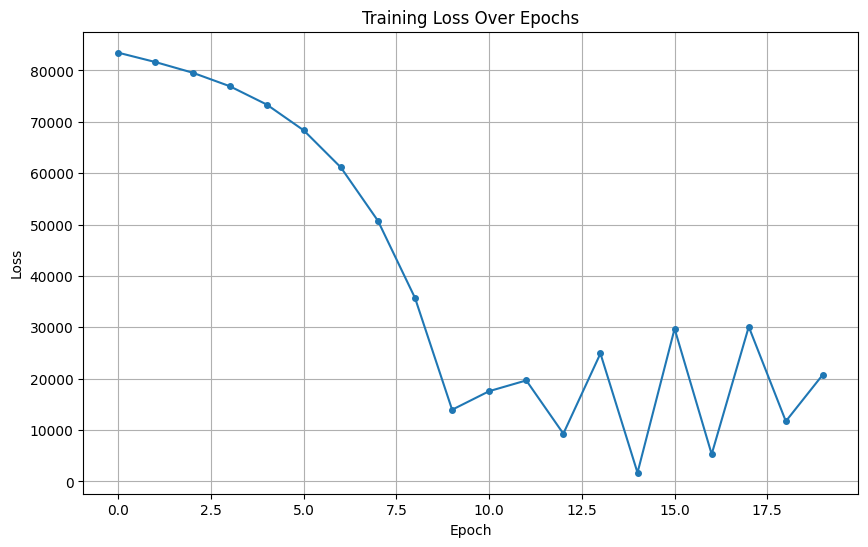

In [ ]:
# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', linestyle='-', markersize=4)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


## Exploration

* Try training the model with higher and lower learning rates. This is commonly the most sensitive and important hyperparameter during neural network training.